In [36]:

# import re
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher
from spacy.tokens import Span

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [38]:
# import wikipedia sentences
# candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
candidate_sentences = pd.read_csv("sentences_vn.csv")
candidate_sentences.shape

(488, 1)

In [39]:
candidate_sentences['sentence'].sample(5)

251                                      các bộ phim từ các quốc gia không nói tiếng Anh đã trở nên thành công.
101                                                                                cô ấy nhắm mắt và gục xuống.
54     những anh hùng như vậy đã sẵn sàng với những câu nói đơn điệu, chơi chữ và những câu châm biếm khô khan.
198    bộ phim được chia thành năm câu chuyện: sự hiện ra, bàn tay, con mèo đen, câu lạc bộ tự sát và der spuk.
479                           những mô hình này được thiết kế bởi nhà thiết kế diecast nổi tiếng eric tscherne.
Name: sentence, dtype: object

In [40]:
# doc = nlp("the drawdown process is governed by astm standard d823")
doc = nlp("bối rối và thất vọng, connie quyết định rời đi một mình.")
print(doc)

for tok in doc:
  print(tok.text, "...", tok.dep_)

bối rối và thất vọng, connie quyết định rời đi một mình.
bối ... compound
rối ... compound
và ... compound
thất ... nsubj
vọng ... ccomp
, ... punct
connie ... compound
quyết ... nsubj
định ... ROOT
rời ... dobj
đi ... dobj
một ... compound
mình ... dobj
. ... punct


In [41]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""  # dependency tag of previous token in the sentence
    prv_tok_text = ""  # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################

    for tok in nlp(sent):
        ## chunk 2
        # nếu token là một dấu chấm câu thì chuyển sang token tiếp theo
        if tok.dep_ != "punct":
            # check: token có phải là một từ ghép hay không
            if tok.dep_ == "compound":
                prefix = tok.text
                # nếu từ trước đó cũng là một 'từ ghép' thì hãy thêm từ hiện tại vào nó
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text

            # check: token là một bổ ngữ hay không
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # nếu từ trước đó cũng là một 'từ ghép' thì hãy thêm từ hiện tại vào nó
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text

            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""

            ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " " + tok.text

            ## chunk 5
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
    #############################################################

    return [ent1.strip(), ent2.strip()]


In [42]:
get_entities("bối rối và thất vọng, connie quyết định rời đi một mình.")

['connie quyết', 'một mình']

In [43]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
    entity_pairs.append(get_entities(i))

100%|██████████| 488/488 [00:04<00:00, 114.10it/s]


In [44]:
entity_pairs[10:20]

[['chúng', 'trải'],
 ['cũng kinh doanh quốc', ''],
 ['', 'robertson giám phim'],
 ['bản nhạc và bản hiện', ''],
 ['bộ phim', 'trong quyền thương'],
 ['', 'làm bị'],
 ['vụ bắt giữ', ''],
 ['', 'của cô tấn công'],
 ['tả selene gallio', ''],
 ['', '']]

In [45]:

def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object
    matcher = Matcher(nlp.vocab)

    #define the pattern
    pattern = [[{
        'DEP': 'ROOT'
    }, {
        'DEP': 'prep',
        'OP': "?"
    }, {
        'DEP': 'agent',
        'OP': "?"
    }, {
        'POS': 'ADJ',
        'OP': "?"
    }]]

    matcher.add("matching_1", patterns = pattern)

    matches = matcher(doc)
    k = len(matches) - 1  
    # print("matches: ", matches)
    # print("type(matches): ", type(matches))
    # print("len(matches): ", len(matches))
    # print("k: ", k)
    
    tmpSpan = ""
    if len(matches) >= 1:
      span = doc[matches[k][1]:matches[k][2]]
      tmpSpan = span.text
      # print("span: ", span.text)
      # print("type(span): ", type(span.text))
      # print("---")

    # return (span.text)
    return(tmpSpan)

In [46]:
# get_relation("John completed the task")
get_relation("bối rối và thất vọng, connie quyết định rời đi một mình.")

'định'

In [47]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 488/488 [00:04<00:00, 112.36it/s]


In [48]:
pd.Series(relations).value_counts()[:50]

với        15
tháng      15
có         14
nhạc       12
ảnh        12
được       10
nhất        9
hoan        8
diễn        8
tôi         7
của         6
đầu         6
kiến        5
hành        5
những       5
cầu         5
cảm         5
cùng        5
thành       4
tiên        4
án          3
nhau        3
sung        3
viên        3
giám        3
do          3
địa         3
ra          3
thương      3
kịch        3
phương      3
loạt        3
làm         3
nó          3
thật        3
cung        3
giới        3
thất        2
theo        2
chính       2
aquaman     2
giờ         2
hậu         2
lillis      2
đại         2
chương      2
lại         2
giao        2
nhận        2
cố          2
dtype: int64

In [49]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

# print('source', len(source))
# print('target', len(target))
# print('edge', len(relations))

kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

In [50]:
# create a directed-graph from a dataframe
G = nx.from_pandas_edgelist(kg_df[kg_df['edge'] == "composed by"],
                            "source",
                            "target",
                            edge_attr=True,
                            create_using=nx.MultiDiGraph())

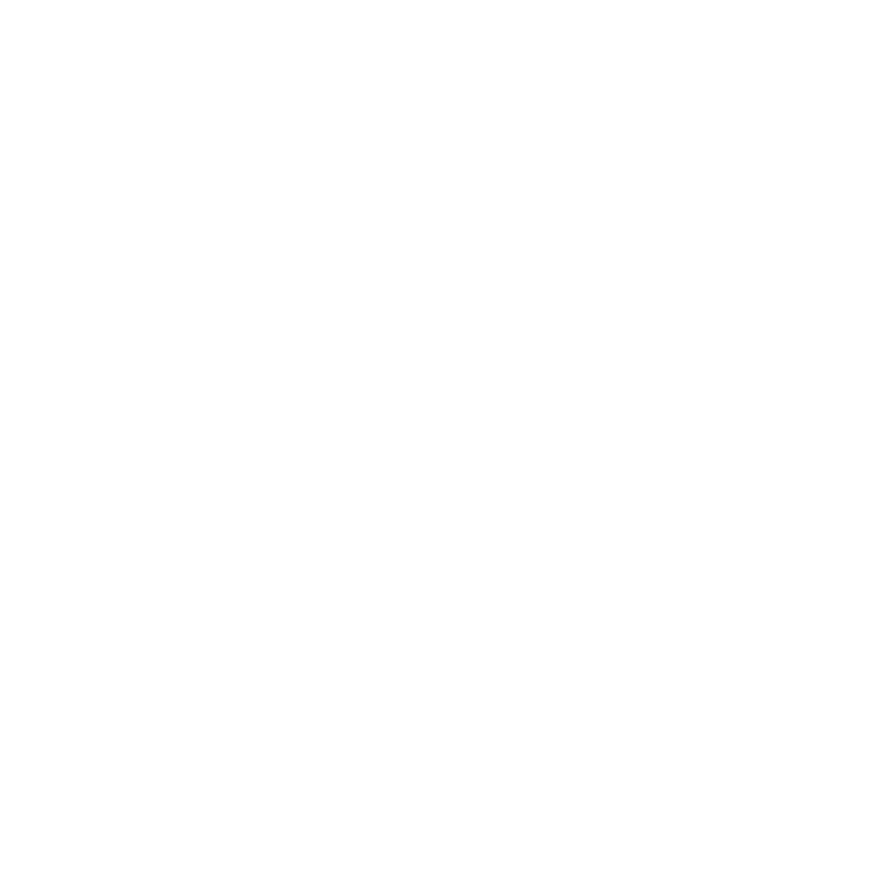

In [ ]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5)  # k regulates the distance between nodes
nx.draw(G,
        with_labels=True,
        node_color='skyblue',
        node_size=1500,
        edge_cmap=plt.cm.Blues,
        pos=pos)
plt.show()